# **Pre-ETL**

### **Library Installation**

In [1]:
!pip install pyspark

In [2]:
!pip install google-play-scraper

     |████████████████████████████████| 52 kB 1.1 MB/s 
  Created wheel for google-play-scraper: filename=google_play_scraper-1.0.2-py3-none-any.whl size=24393 sha256=6844671ae06418f31202df102ac412723b741f55212bd2ff6cace23c2129db84
  Stored in directory: /root/.cache/pip/wheels/98/99/eb/bbb9d24a5c526980647efc10336eaaeffcf07749f581111128
Successfully built google-play-scraper


In [4]:
!pip install deep-translator

In [5]:
!pip install tweet-preprocessor

In [6]:
!pip install emoji

     |████████████████████████████████| 170 kB 5.0 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=17dc402a26ffd65dd5bd7a330ff48b58729edb491d37771569c351facc089c95
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


In [3]:
!pip install azure-storage-blob==2.1.0

     |████████████████████████████████| 88 kB 3.1 MB/s 
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 3.6 MB 47.5 MB/s 


### **Importing Libraries**

In [9]:
# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, StructType, StructField, TimestampType, FloatType
from pyspark.sql.functions import udf, col

# Scraping Libraries
import tweepy as tw
from google_play_scraper import app, Sort, reviews_all

# Text Processing Libraries
from deep_translator import GoogleTranslator
from textblob import TextBlob
from nltk.corpus import stopwords
import re
import nltk
import preprocessor as p
import emoji

# Load Libraries with Azure Storage Blob
from azure.storage.blob import (
    BlockBlobService
)
import io

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **API Key**

In [10]:
#Insert API Key File
APIKey = pd.read_csv('APIKey.csv')

Twitter Key

In [13]:
# API key, API secret, access token, access token secret
API_KEY = APIKey['TwitterKey'][0]
API_SECRET = APIKey['TwitterSecret'][0]
ACCESS_TOKEN = APIKey['TwitterToken'][0]
ACCESS_TOKEN_SECRET = APIKey['TwitterTokenSecret'][0]

# Authentification
auth = tw.OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# API
api = tw.API(auth, wait_on_rate_limit=True)

Azure Storage

In [15]:
accountName = APIKey['AzureName'][0]
accountKey = APIKey['AzurekKey'][0]
containerName = APIKey['AzureContainer'][0]

### **Creating Spark Session**

In [16]:
spark = SparkSession.builder.appName("AnterajaRevs").getOrCreate()

### **Some Configurations**

In [17]:
p.set_options(p.OPT.MENTION, p.OPT.EMOJI, p.OPT.HASHTAG, p.OPT.RESERVED, p.OPT.SMILEY, p.OPT.URL)
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


# **Extract**

### **A. Scraping Twitter Data**

In [18]:
# Define the search term and the date_since date as variables
search_words = "anteraja -from:anteraja_id lang:id"
date_year = "2021"
date_month = "10"
date_days = range(10, 18)
date_time = "2315"
screen_name = []
text = []
created_at = []

for date_day in date_days:
  date_since = date_year + date_month + str(date_day) + date_time 
  date_until = date_year + date_month + str(date_day+1) + date_time

  tweets = tw.Cursor(api.search_full_archive,
                    environment_name="TwitterResearch",
                    query=search_words,
                    fromDate=date_since,
                    toDate=date_until).items(100)
  
  for tweet in tweets:
    screen_name.append(tweet.user.screen_name)
    text.append(tweet.text)
    created_at.append(tweet.created_at)

In [19]:
tweet_data = pd.DataFrame(
    {'username': screen_name,
     'date': created_at,
     'tweet': text
    })

In [20]:
tweet_data

,username,date,tweet
0,GrabID,2021-10-11 23:09:02,@ezizyaa Kalau itu tergantung kebijakan dari A...
1,GrabID,2021-10-11 22:59:46,@ezizyaa Hai Kak :) buat pengiriman antar kota...
2,marsupilapila,2021-10-11 21:36:13,@anteraja_id mau tanya paket dengan nomor resi...
3,aLpyPutraa,2021-10-11 21:19:56,RT @amiranh_: Halo @anteraja_id saya pesan ops...
4,Naanganang,2021-10-11 21:13:43,@anteraja_id min ini kenapa dari minggu udah a...
...,...,...,...
795,IndraNubia,2021-10-18 10:53:30,@anteraja_id @MediaKonsumenID Ini foto saya da...
796,IndraNubia,2021-10-18 10:53:01,@anteraja_id @MediaKonsumenID Kalian bisa liat...
797,Irfan22031,2021-10-18 10:51:00,@anteraja_id Sudah seminggu ga dikirim kerumah2..
798,iEkaJahe,2021-10-18 10:50:44,@anteraja_id paket sy mpe slr nyangkut trus di...


In [21]:
# Defining Spark schema
schema_twt = 'username STRING, date TIMESTAMP, tweet STRING'

In [22]:
# Converting data type of 'date' column from string to datetime
tweet_data['date'] = pd.to_datetime(tweet_data['date'])

In [23]:
# Creating Spark dataframe using defined schema
df_Twitter = spark.createDataFrame(tweet_data[['username', 'date', 'tweet']], schema_twt) 

In [24]:
df_Twitter.printSchema()

root
 |-- username: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- tweet: string (nullable = true)



In [25]:
df_Twitter.show(n=2)

+--------+-------------------+--------------------+
|username|               date|               tweet|
+--------+-------------------+--------------------+
|  GrabID|2021-10-11 23:09:02|@ezizyaa Kalau it...|
|  GrabID|2021-10-11 22:59:46|@ezizyaa Hai Kak ...|
+--------+-------------------+--------------------+
only showing top 2 rows



### **B. Scraping Google Play Store Review**

In [26]:
id_reviews = reviews_all(
                        'id.anteraja.aca',
                        sleep_milliseconds=0, # defaults to 0
                        lang='en', # defaults to 'en'
                        country='id', # defaults to 'us'
                        sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
                        )

In [27]:
# Defining Spark schema
schema_ps = 'userName STRING, at TIMESTAMP, content STRING'

In [28]:
df_google_play = pd.DataFrame(np.array(id_reviews), columns=['review'])
df_google_play = df_google_play.join(pd.DataFrame(df_google_play.pop('review').tolist()))

# Converting data type of 'at' column from string to datetime
df_google_play['at'] = pd.to_datetime(df_google_play['at'])

In [29]:
# Creating Spark dataframe using defined schema
df_google_play = spark.createDataFrame(df_google_play[['userName', 'at', 'content']], schema_ps)

In [30]:
df_google_play.printSchema()

root
 |-- userName: string (nullable = true)
 |-- at: timestamp (nullable = true)
 |-- content: string (nullable = true)



In [31]:
df_google_play.show(n=2)

+-------------+-------------------+--------------------+
|     userName|                 at|             content|
+-------------+-------------------+--------------------+
|  Lahma Urtap|2021-12-05 05:11:05|Gak usah maaf2, t...|
|Michael T. A.|2021-12-05 03:40:07|Order pake Next D...|
+-------------+-------------------+--------------------+
only showing top 2 rows



# **Transform**

### **A. Creating Functions**

#### **1. Defining Translator Function**

In [33]:
def translator(text):
  text = GoogleTranslator(source='id', target='en').translate(text)
  return text

#### **2. Defining Cleansing Function**

In [34]:
def cleaner(text):
    text = re.sub("@[A-Za-z0-9]+", "", text) #Remove @ sign
    text = ''.join(c for c in text if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    text = text.replace("#", "").replace("_", "") #Remove hashtag sign but keep the text
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha()) #Remove non-english tweets (not 100% success)
    return text

udf_clean = udf(lambda x:cleaner(x), StringType())

#### **3. Defining Sentiment Score Function**

In [35]:
def sentiment_score(text):
  blob = TextBlob(str(text))
  score = blob.polarity
  return score

udf_sentiment_score = udf(lambda x:sentiment_score(x), FloatType())

#### **4. Defining Sentiment Analysis Function**

In [36]:
def sentiment(sentiment_score):
   if sentiment_score > 0:
    return "positive"
   elif sentiment_score < 0:
    return "negative"
   else:
    return "neutral"  

udf_sentiment = udf(lambda x:sentiment(x), StringType())

### **B. Applying Functions to Twitter Data**

In [37]:
#Create pandas DataFrame, to avoid exceeding rate limit on Google Translator Rate Limit
pd_Twitter = pd.DataFrame(df_Twitter.toPandas()) 
pd_Twitter.head()

,username,date,tweet
0,GrabID,2021-10-11 23:09:02,@ezizyaa Kalau itu tergantung kebijakan dari A...
1,GrabID,2021-10-11 22:59:46,@ezizyaa Hai Kak :) buat pengiriman antar kota...
2,marsupilapila,2021-10-11 21:36:13,@anteraja_id mau tanya paket dengan nomor resi...
3,aLpyPutraa,2021-10-11 21:19:56,RT @amiranh_: Halo @anteraja_id saya pesan ops...
4,Naanganang,2021-10-11 21:13:43,@anteraja_id min ini kenapa dari minggu udah a...


In [38]:
# Applying Translator Function (Pandas)
pd_Twitter['tweet'] = pd_Twitter['tweet'].map(lambda x: translator(x))

In [39]:
pd_Twitter.tail()

,username,date,tweet
795,IndraNubia,2021-10-18 10:53:30,@anteraja_id @MediaKonsumenID This is a photo ...
796,IndraNubia,2021-10-18 10:53:01,@anteraja_id @MediaKonsumenID You can see the ...
797,Irfan22031,2021-10-18 10:51:00,@anteraja_id It's been a week that it hasn't b...
798,iEkaJahe,2021-10-18 10:50:44,@anteraja_id my package got stuck and then in ...
799,ro2anisa,2021-10-18 10:49:21,@anteraja_id Thank you @anteraja_id my shipmen...


In [40]:
#Turn Pandas to Spark (For Faster Computation)
df_Twitter=spark.createDataFrame(pd_Twitter)

In [41]:
# Applying Cleansing Function
df_Twitter = df_Twitter.withColumn("tweet", udf_clean(col("tweet"))).select("username", "date", "tweet")

In [42]:
df_Twitter.show(n=5)

+-------------+-------------------+--------------------+
|     username|               date|               tweet|
+-------------+-------------------+--------------------+
|       GrabID|2021-10-11 23:09:02|If it on the poli...|
|       GrabID|2021-10-11 22:59:46|Hi Sis :) for int...|
|marsupilapila|2021-10-11 21:36:13|id want to ask fo...|
|   aLpyPutraa|2021-10-11 21:19:56|: Hello id I orde...|
|   Naanganang|2021-10-11 21:13:43|id this min why s...|
+-------------+-------------------+--------------------+
only showing top 5 rows



In [43]:
# Applying Sentiment Score Function
df_Twitter = df_Twitter.withColumn("sentiment_score", udf_sentiment_score(col("tweet"))).select("username", "date", "tweet", "sentiment_score")

In [44]:
df_Twitter.show(n=5)

+-------------+-------------------+--------------------+---------------+
|     username|               date|               tweet|sentiment_score|
+-------------+-------------------+--------------------+---------------+
|       GrabID|2021-10-11 23:09:02|If it on the poli...|            0.0|
|       GrabID|2021-10-11 22:59:46|Hi Sis :) for int...|           0.25|
|marsupilapila|2021-10-11 21:36:13|id want to ask fo...|            0.0|
|   aLpyPutraa|2021-10-11 21:19:56|: Hello id I orde...|            0.0|
|   Naanganang|2021-10-11 21:13:43|id this min why s...|            0.0|
+-------------+-------------------+--------------------+---------------+
only showing top 5 rows



In [45]:
# Applying Sentiment Analysis Function
df_Twitter = df_Twitter.withColumn("sentiment", udf_sentiment(col("sentiment_score"))).select("username", "date", "tweet", "sentiment_score", "sentiment")

In [46]:
df_Twitter.show(n=7)

+--------------+-------------------+--------------------+---------------+---------+
|      username|               date|               tweet|sentiment_score|sentiment|
+--------------+-------------------+--------------------+---------------+---------+
|        GrabID|2021-10-11 23:09:02|If it on the poli...|            0.0|  neutral|
|        GrabID|2021-10-11 22:59:46|Hi Sis :) for int...|           0.25| positive|
| marsupilapila|2021-10-11 21:36:13|id want to ask fo...|            0.0|  neutral|
|    aLpyPutraa|2021-10-11 21:19:56|: Hello id I orde...|            0.0|  neutral|
|    Naanganang|2021-10-11 21:13:43|id this min why s...|            0.0|  neutral|
|  nanang_indra|2021-10-11 21:09:07|id hello sis rece...|            0.0|  neutral|
|cabangpurnamaa|2021-10-11 19:16:04|, I have to be fu...|            0.0|  neutral|
+--------------+-------------------+--------------------+---------------+---------+
only showing top 7 rows



In [47]:
export_Twitter = df_Twitter.select("username", "date", "tweet", "sentiment_score", "sentiment")

In [48]:
#Create pandas DataFrame, to export data
pd_Twitter = pd.DataFrame(export_Twitter.toPandas())

### **C. Applying Functions to Google Play Store Review Data**

In [49]:
#Create pandas DataFrame, to avoid exceeding rate limit on Google Translator Rate Limit
pd_google_play = pd.DataFrame(df_google_play.toPandas()) 
pd_google_play.head()

,userName,at,content
0,Lahma Urtap,2021-12-05 05:11:05,"Gak usah maaf2, tingkatin aja layananmu."
1,Michael T. A.,2021-12-05 03:40:07,"Order pake Next Day, tapi barang gak nyampe es..."
2,Krisdian Agung,2021-12-05 02:41:05,Friendly UI and you can choose what type of pa...
3,Sky Ultra,2021-12-04 21:01:30,Service jelek. Kurir membohongi penerima.
4,Dian Herdiyani,2021-12-04 14:28:34,Good


In [50]:
pd_google_play = pd_google_play[pd_google_play['at'].dt.strftime('%Y-%m-%d') >= "2021-11-11"]
pd_google_play

,userName,at,content
0,Lahma Urtap,2021-12-05 05:11:05,"Gak usah maaf2, tingkatin aja layananmu."
1,Michael T. A.,2021-12-05 03:40:07,"Order pake Next Day, tapi barang gak nyampe es..."
2,Krisdian Agung,2021-12-05 02:41:05,Friendly UI and you can choose what type of pa...
3,Sky Ultra,2021-12-04 21:01:30,Service jelek. Kurir membohongi penerima.
4,Dian Herdiyani,2021-12-04 14:28:34,Good
...,...,...,...
256,Olivia IPD,2021-11-11 02:34:41,"Pengirimannya cepat, bahkan lebih cepat dari p..."
257,Richard Sebastian,2021-11-11 02:28:34,Pengirimannya cepat dan banyak promonya juga
258,Rifka Fitriana Rahmadani,2021-11-11 02:27:34,works well and really help if you need to send...
259,Devinta Rhista Purnama,2021-11-11 01:57:10,Search history AWB tidak bisa menggunakan nama...


In [51]:
#Translate from pandas dataframe to GoogleTranslator API
pd_google_play['content'] = pd_google_play['content'].map(lambda x: translator(x))

In [52]:
pd_google_play.tail()

,userName,at,content
256,Olivia IPD,2021-11-11 02:34:41,"Fast delivery, even faster than expected. Alwa..."
257,Richard Sebastian,2021-11-11 02:28:34,Fast delivery and lots of promotions too
258,Rifka Fitriana Rahmadani,2021-11-11 02:27:34,works well and really help if you need to send...
259,Devinta Rhista Purnama,2021-11-11 01:57:10,Search history AWB can't use the recipient's n...
260,Sitifatimahaz,2021-11-11 01:55:50,The promo wadidaw helps


In [53]:
pd_google_play = pd_google_play[pd_google_play['content'].notna()]

In [54]:
pd_google_play.head()

,userName,at,content
0,Lahma Urtap,2021-12-05 05:11:05,"No need to apologize, just improve your service."
1,Michael T. A.,2021-12-05 03:40:07,"Order using Next Day, but the item doesn't arr..."
2,Krisdian Agung,2021-12-05 02:41:05,Friendly UI and you can choose what type of pa...
3,Sky Ultra,2021-12-04 21:01:30,Bad service. Courier lied to the recipient.
4,Dian Herdiyani,2021-12-04 14:28:34,good


In [55]:
#Turn Pandas to Spark (For Faster Computation)
df_google_play=spark.createDataFrame(pd_google_play)

In [56]:
df_google_play.show(2)

+-------------+-------------------+--------------------+
|     userName|                 at|             content|
+-------------+-------------------+--------------------+
|  Lahma Urtap|2021-12-05 05:11:05|No need to apolog...|
|Michael T. A.|2021-12-05 03:40:07|Order using Next ...|
+-------------+-------------------+--------------------+
only showing top 2 rows



In [57]:
# Applying Cleansing Function
df_google_play = df_google_play.withColumn("content", udf_clean(col("content"))).select("userName", "at", "content")

In [58]:
df_google_play.show(5)

+--------------+-------------------+--------------------+
|      userName|                 at|             content|
+--------------+-------------------+--------------------+
|   Lahma Urtap|2021-12-05 05:11:05|No need to apolog...|
| Michael T. A.|2021-12-05 03:40:07|Order Next Day , ...|
|Krisdian Agung|2021-12-05 02:41:05|Friendly and you ...|
|     Sky Ultra|2021-12-04 21:01:30|Bad service . Cou...|
|Dian Herdiyani|2021-12-04 14:28:34|                good|
+--------------+-------------------+--------------------+
only showing top 5 rows



In [59]:
# Applying Sentiment Score Function
df_google_play = df_google_play.withColumn("sentiment_score", udf_sentiment_score(col("content"))).select("userName", "at", "content", "sentiment_score")

In [60]:
df_google_play.show(n=5)

+--------------+-------------------+--------------------+---------------+
|      userName|                 at|             content|sentiment_score|
+--------------+-------------------+--------------------+---------------+
|   Lahma Urtap|2021-12-05 05:11:05|No need to apolog...|            0.0|
| Michael T. A.|2021-12-05 03:40:07|Order Next Day , ...|            0.0|
|Krisdian Agung|2021-12-05 02:41:05|Friendly and you ...|     0.40416667|
|     Sky Ultra|2021-12-04 21:01:30|Bad service . Cou...|           -0.7|
|Dian Herdiyani|2021-12-04 14:28:34|                good|            0.7|
+--------------+-------------------+--------------------+---------------+
only showing top 5 rows



In [61]:
# Applying Sentiment Category Function
df_google_play = df_google_play.withColumn("sentiment", udf_sentiment(col("sentiment_score"))).select("userName", "at", "content", "sentiment_score", "sentiment")

In [62]:
df_google_play.show(n=5)

+--------------+-------------------+--------------------+---------------+---------+
|      userName|                 at|             content|sentiment_score|sentiment|
+--------------+-------------------+--------------------+---------------+---------+
|   Lahma Urtap|2021-12-05 05:11:05|No need to apolog...|            0.0|  neutral|
| Michael T. A.|2021-12-05 03:40:07|Order Next Day , ...|            0.0|  neutral|
|Krisdian Agung|2021-12-05 02:41:05|Friendly and you ...|     0.40416667| positive|
|     Sky Ultra|2021-12-04 21:01:30|Bad service . Cou...|           -0.7| negative|
|Dian Herdiyani|2021-12-04 14:28:34|                good|            0.7| positive|
+--------------+-------------------+--------------------+---------------+---------+
only showing top 5 rows



In [63]:
export_google_play = df_google_play.select("userName", "at", "content", "sentiment_score", "sentiment")

In [64]:
#Create pandas DataFrame, to export data
pd_google_play = pd.DataFrame(export_google_play.toPandas()) 

# **Load**

In [68]:
#Load Twitter data (pd_Twitter) to Azure Storage

loadTwitter = io.StringIO()
loadTwitter = pd_Twitter.to_csv(index_label="idx", encoding = "utf-8")

blobService = BlockBlobService(account_name=accountName, account_key=accountKey)
blobService.create_blob_from_text(containerName, 'TwitterSentimentAnalysis.csv', loadTwitter)

In [70]:
#Load Twitter data (pd_Twitter) to Azure Storage

loadPlaystore = io.StringIO()
loadPlaystore = pd_google_play.to_csv(index_label="idx", encoding = "utf-8")

blobService = BlockBlobService(account_name=accountName, account_key=accountKey)
blobService.create_blob_from_text(containerName, 'PlaystoreSentimentAnalysis.csv', loadPlaystore)

# **Basic Viz**

### **A. Twitter Sentiment Analysis**

In [71]:
tmp_Twitter = pd_Twitter.groupby(pd_Twitter.date.dt.day).agg('mean')

In [72]:
tmp_Twitter = tmp_Twitter.reset_index()

In [73]:
tmp_Twitter

,date,sentiment_score
0,11,0.105363
1,12,0.068682
2,13,0.025952
3,14,0.037947
4,15,-0.002875
5,16,0.042272
6,17,0.070382
7,18,0.106431


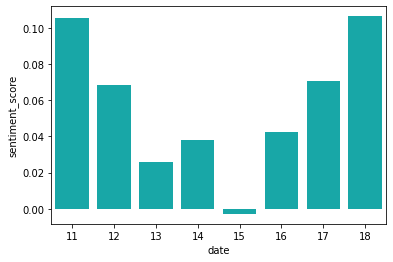

In [74]:
sns.barplot(x="date", y="sentiment_score", color="c", data=tmp_Twitter)

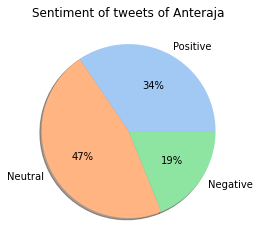

In [75]:
sentiment_Twitter_dict = {'positive': 0, 'negative': 0, 'neutral': 0}
for sentiment in pd_Twitter["sentiment"]:
  if sentiment == "positive":
      sentiment_Twitter_dict['positive'] += 1
  elif sentiment == "neutral":
      sentiment_Twitter_dict['neutral'] += 1
  elif sentiment == "negative":
      sentiment_Twitter_dict['negative'] += 1

sentiment_Twitter = np.array([sentiment_Twitter_dict["positive"], sentiment_Twitter_dict["neutral"], sentiment_Twitter_dict["negative"]])
labels = ["Positive", "Neutral", "Negative"]
colors = sns.color_palette('pastel')[0:5]

plt.pie(sentiment_Twitter, labels=labels, colors=colors, shadow=True, autopct='%.0f%%')
plt.title("Sentiment of tweets of Anteraja")
plt.show()

### **B. Google Play Sentiment Analysis**

In [76]:
tmp_google_play = pd_google_play.groupby(pd_google_play['at'].dt.day).agg('mean')

In [77]:
tmp_google_play = tmp_google_play.reset_index()

In [78]:
tmp_google_play

,at,sentiment_score
0,1,0.316667
1,2,0.040536
2,3,0.469333
3,4,0.096244
4,5,0.134722
5,11,0.073112
6,12,0.216342
7,13,0.091000
8,14,0.040044
9,15,0.010442


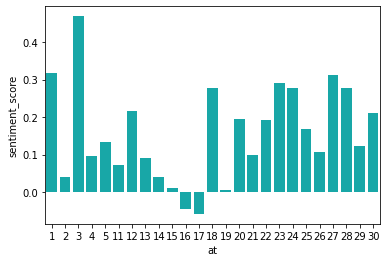

In [79]:
sns.barplot(x="at", y="sentiment_score", color="c", data=tmp_google_play)

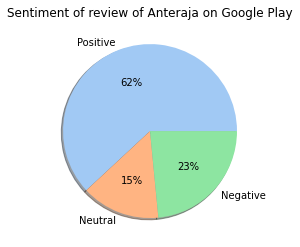

In [80]:
sentiment_google_play_dict = {'positive' : 0, 'negative' : 0, 'neutral': 0}
for sentiment in pd_google_play["sentiment"]:
  if sentiment == "positive":
      sentiment_google_play_dict['positive'] += 1
  elif sentiment == "neutral":
      sentiment_google_play_dict['neutral'] += 1
  elif sentiment == "negative":
      sentiment_google_play_dict['negative'] += 1

sentiment_google_play = np.array([sentiment_google_play_dict["positive"], sentiment_google_play_dict["neutral"], sentiment_google_play_dict["negative"]])
labels = ["Positive", "Neutral", "Negative"]
colors = sns.color_palette('pastel')[0:5]

plt.pie(sentiment_google_play, labels=labels, colors=colors, shadow=True, autopct='%.0f%%')
plt.title("Sentiment of review of Anteraja on Google Play")
plt.show() 